In [1]:
# schiller test --> iodine that stains different on abnormal cells on cervix
# hinsellman --> coloscopy using scope on cervix
# cytology --> pap smear
# biopsy --> biopsy 
# These indicate the RESULTS of these tests, assuming they were carried out. 1 means suspect screening, 0 means okay screening. 

# dx columns mean previous cervical diagnosis 
# stds_number is the sum over all std columns
# Cant figure out what stds_n_diagnosis is, though. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.impute import MissingIndicator, SimpleImputer
import matplotlib.pyplot as plt
import miceforest as mf
from miceforest import mean_match_default
import seaborn as sns
from lightgbm import LGBMClassifier
import inspect 
import warnings
import scipy.stats as stats
from tempfile import mkdtemp
from joblib import Memory
from shutil import rmtree
from mice_imputer import *
import prince as pr

In [3]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv")

# Encode missings

In [4]:
df = df.replace({"?": pd.NA})

# Rename columns to be more manageable

In [5]:
df.columns.values

array(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)',
       'Smokes (packs/year)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs',
       'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis',
       'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
       'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy'], dtype=object)

In [6]:
new_names = df.columns 
to_rep = {
    "Number" : "n",
    "Contraceptives" : "bc", 
    "Num" : "n",
    "-" : "_",
    "of" : "",
    " " : "_", 
    "(" : "",
    ")" : "",
    "/" : "_",
    ":" : "_", 
    "__" : "_"
}

for key, value in to_rep.items(): 
    new_names = new_names.str.replace(key, value, regex = True)

new_names = new_names.str.lower()

df = df.set_axis(new_names, axis = 1)

df.columns.values

array(['age', 'n_sexual_partners', 'first_sexual_intercourse',
       'n_pregnancies', 'smokes', 'smokes_years', 'smokes_packs_year',
       'hormonal_bc', 'hormonal_bc_years', 'iud', 'iud_years', 'stds',
       'stds_number', 'stds_condylomatosis',
       'stds_cervical_condylomatosis', 'stds_vaginal_condylomatosis',
       'stds_vulvo_perineal_condylomatosis', 'stds_syphilis',
       'stds_pelvic_inflammatory_disease', 'stds_genital_herpes',
       'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv',
       'stds_hepatitis_b', 'stds_hpv', 'stds_n_diagnosis',
       'stds_time_since_first_diagnosis',
       'stds_time_since_last_diagnosis', 'dx_cancer', 'dx_cin', 'dx_hpv',
       'dx', 'hinselmann', 'schiller', 'citology', 'biopsy'], dtype=object)

In [7]:
df = df.apply(pd.to_numeric, axis = 1).convert_dtypes() # convert_dtypes not working without the apply() call. Probably due to the earlier replace statement, but fiddled for an hour and no dice.

# Verifies that the count of stds is the sum over all std columns. 

In [8]:
df[df.columns[df.columns.str.startswith("stds_")]]

,stds_number,stds_condylomatosis,stds_cervical_condylomatosis,stds_vaginal_condylomatosis,stds_vulvo_perineal_condylomatosis,stds_syphilis,stds_pelvic_inflammatory_disease,stds_genital_herpes,stds_molluscum_contagiosum,stds_aids,stds_hiv,stds_hepatitis_b,stds_hpv,stds_n_diagnosis,stds_time_since_first_diagnosis,stds_time_since_last_diagnosis
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
854,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
855,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>


In [9]:
all((df[df.columns[df.columns.str.startswith("stds_")]].drop(["stds_time_since_first_diagnosis", "stds_time_since_last_diagnosis", "stds_n_diagnosis", "stds_number"], axis = 1).sum(axis = 1) == df.stds_number).dropna())

True

# Drop n_diagnosis col

In [10]:
df.drop(["stds_n_diagnosis"], axis = 1, inplace = True)

# Check missingness 

In [11]:
df.isna().mean().sort_values(ascending = False)

stds_time_since_last_diagnosis        0.917249
stds_time_since_first_diagnosis       0.917249
iud                                   0.136364
iud_years                             0.136364
hormonal_bc                           0.125874
hormonal_bc_years                     0.125874
stds_syphilis                         0.122378
stds_vulvo_perineal_condylomatosis    0.122378
stds_hpv                              0.122378
stds_hepatitis_b                      0.122378
stds_hiv                              0.122378
stds_aids                             0.122378
stds_molluscum_contagiosum            0.122378
stds_genital_herpes                   0.122378
stds_pelvic_inflammatory_disease      0.122378
stds_vaginal_condylomatosis           0.122378
stds_cervical_condylomatosis          0.122378
stds_condylomatosis                   0.122378
stds_number                           0.122378
stds                                  0.122378
n_pregnancies                         0.065268
n_sexual_part

# Drop time since std diagnoses

In [12]:
df.drop(df.columns.values[df.columns.str.startswith("stds_time")], axis = 1, inplace = True)

# Check for constant columns

In [13]:
const = df.nunique() == 1

if any(const):
    print("Deleting constant columns: {}".format(df.columns.values[const]))
    df.drop(df.columns.values[const], axis = 1, inplace = True)

Deleting constant columns: ['stds_cervical_condylomatosis' 'stds_aids']


In [14]:
df

,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes,smokes_years,smokes_packs_year,hormonal_bc,hormonal_bc_years,iud,...,stds_hepatitis_b,stds_hpv,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,citology,biopsy
0,18,4,15,1,0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,15,1,14,1,0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,34,1,<NA>,1,0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,52,5,16,4,1,37.0,37.0,1,3.0,0,...,0,0,1,0,1,0,0,0,0,0
4,46,3,21,4,0,0.0,0.0,1,15.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34,3,18,0,0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
854,32,2,19,1,0,0.0,0.0,1,8.0,0,...,0,0,0,0,0,0,0,0,0,0
855,25,2,17,0,0,0.0,0.0,1,0.08,0,...,0,0,0,0,0,0,0,0,1,0
856,33,2,24,2,0,0.0,0.0,1,0.08,0,...,0,0,0,0,0,0,0,0,0,0


# Iud/smoking years are always >0 if you have an IUD/smoke.

In [15]:
np.any((df.iud == 1) & (df.iud_years == 0))

False

In [16]:
np.any((df.smokes == 1) & (df.smokes_years == 0))

False

# PCA on STD Columns

In [17]:
stds = df[df.columns.values[df.columns.str.startswith("stds_")]].drop("stds_number", axis = 1).dropna()

In [18]:
scaler = StandardScaler()
pc = PCA()
stds_s = scaler.fit_transform(stds)
pc.fit(stds_s)

PCA()

In [19]:
eigs = pc.explained_variance_ratio_
eigs_cum = np.cumsum(eigs)
ind = [i + 1 for i in range(len(eigs))]
print(eigs_cum)

[0.21281557 0.33578793 0.43706542 0.53727932 0.6374123  0.73754528
 0.83624698 0.92480148 0.99909275 1.        ]


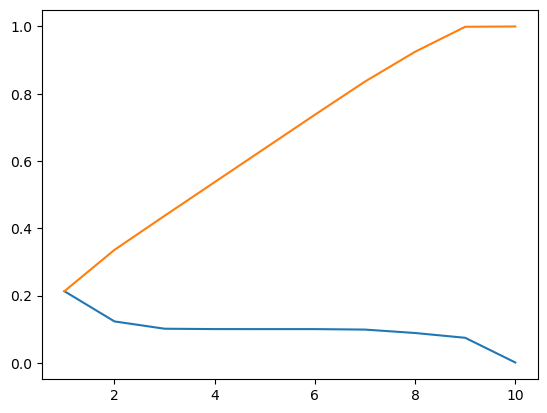

In [20]:
plt.plot(ind, eigs)
plt.plot(ind, eigs_cum)

In [21]:
pc.explained_variance_[0:3]

array([2.13098567, 1.23135892, 1.01412168])

In [22]:
loadings = pc.components_[0:6].T * np.sqrt(pc.explained_variance_[0:6])

loadmat = pd.DataFrame(np.round(loadings, 4), columns=['PC1', 'PC2', 'PC3', "PC4", "PC5", "PC6"], index=stds.columns.values)
loadmat


,PC1,PC2,PC3,PC4,PC5,PC6
stds_condylomatosis,0.9809,-0.0569,-0.0001,0.0008,0.0000,0.0000
stds_vaginal_condylomatosis,0.4394,-0.1656,0.1930,-0.0104,0.0000,-0.0000
stds_vulvo_perineal_condylomatosis,0.9656,-0.0452,-0.0155,0.0016,-0.0000,0.0000
stds_syphilis,0.0632,0.0832,-0.8210,0.0448,-0.0000,0.0000
stds_pelvic_inflammatory_disease,-0.0179,-0.0192,0.2231,-0.3589,0.8085,-0.1216
stds_genital_herpes,-0.0179,-0.0192,0.2231,-0.3589,-0.5095,-0.6394
stds_molluscum_contagiosum,-0.0179,-0.0192,0.2231,-0.3589,-0.2990,0.7610
stds_hiv,0.1929,0.7636,-0.0030,0.0012,-0.0000,0.0000
stds_hepatitis_b,0.0230,0.7790,0.1598,-0.0071,0.0000,-0.0000
stds_hpv,-0.0253,-0.0273,0.3573,0.7841,0.0000,-0.0000


# Train/Test Data

In [23]:
x = df.drop(["smokes", "hormonal_bc", "iud", "stds", "schiller", "biopsy", "hinselmann"], axis = 1)
x["n_stds"] = x["stds_number"]
x.drop("stds_number", axis = 1, inplace = True)
#x.drop(x.columns.values[x.columns.str.startswith("stds")], axis = 1, inplace = True)
y = df[["biopsy"]].astype("int64")


In [24]:
x.dtypes

age                                     Int64
n_sexual_partners                       Int64
first_sexual_intercourse                Int64
n_pregnancies                           Int64
smokes_years                          Float64
smokes_packs_year                     Float64
hormonal_bc_years                     Float64
iud_years                             Float64
stds_condylomatosis                     Int64
stds_vaginal_condylomatosis             Int64
stds_vulvo_perineal_condylomatosis      Int64
stds_syphilis                           Int64
stds_pelvic_inflammatory_disease        Int64
stds_genital_herpes                     Int64
stds_molluscum_contagiosum              Int64
stds_hiv                                Int64
stds_hepatitis_b                        Int64
stds_hpv                                Int64
dx_cancer                               Int64
dx_cin                                  Int64
dx_hpv                                  Int64
dx                                

In [25]:
x[x.select_dtypes(include=['Int64', 'Float64']).columns.values] = x.select_dtypes(include=['Int64', 'Float64']).astype('float')
# x[x.columns.values[x.columns.str.startswith("stds_")]] = x[x.columns.values[x.columns.str.startswith("stds_")]].astype("bool")
# x[x.columns.values[x.columns.str.startswith("dx")]] = x[x.columns.values[x.columns.str.startswith("dx")]].astype("bool")
# x["citology"] = x.citology.astype("bool")
x.dtypes

age                                   float64
n_sexual_partners                     float64
first_sexual_intercourse              float64
n_pregnancies                         float64
smokes_years                          float64
smokes_packs_year                     float64
hormonal_bc_years                     float64
iud_years                             float64
stds_condylomatosis                   float64
stds_vaginal_condylomatosis           float64
stds_vulvo_perineal_condylomatosis    float64
stds_syphilis                         float64
stds_pelvic_inflammatory_disease      float64
stds_genital_herpes                   float64
stds_molluscum_contagiosum            float64
stds_hiv                              float64
stds_hepatitis_b                      float64
stds_hpv                              float64
dx_cancer                             float64
dx_cin                                float64
dx_hpv                                float64
dx                                

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 987417)

In [27]:
x.stds_condylomatosis.isna().mean()

0.12237762237762238

In [28]:
print(y_train.shape, y_test.shape)
x_train.head()

(643, 1) (215, 1)


,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes_years,smokes_packs_year,hormonal_bc_years,iud_years,stds_condylomatosis,stds_vaginal_condylomatosis,...,stds_molluscum_contagiosum,stds_hiv,stds_hepatitis_b,stds_hpv,dx_cancer,dx_cin,dx_hpv,dx,citology,n_stds
421,26.0,3.0,15.0,NaN,0.0,0.0,0.33,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581,17.0,2.0,15.0,2.0,0.0,0.0,2.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
788,38.0,2.0,19.0,5.0,0.0,0.0,30.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN
59,35.0,3.0,17.0,4.0,0.0,0.0,7.00,0.08,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
646,16.0,1.0,15.0,1.0,0.0,0.0,0.25,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


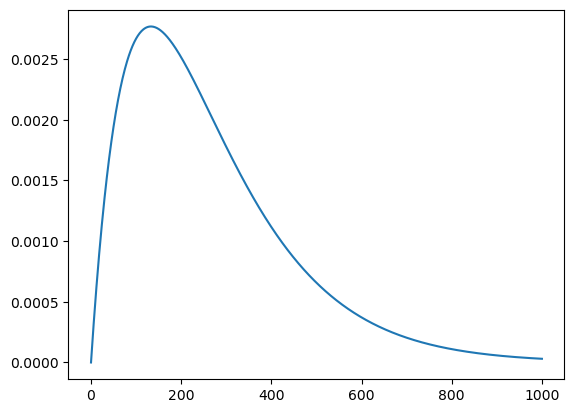

In [29]:
n = 2
p = .0075
# x = stats.nbinom.rvs(n = n, p=p, size = 10000)
# plt.hist(x,density=True, bins = 100)
xl = np.floor(np.linspace(0, 1000, 1000))
plt.plot(xl, stats.nbinom.pmf(xl, n = n, p = p, loc = 1))

In [30]:
pd.DataFrame((stats.nbinom.rvs(size = 10000, n = n, p = p, loc = 1))).describe()

,0
count,10000.000000
mean,267.583200
std,188.632553
min,2.000000
25%,128.000000
50%,225.000000
75%,362.000000
max,1462.000000


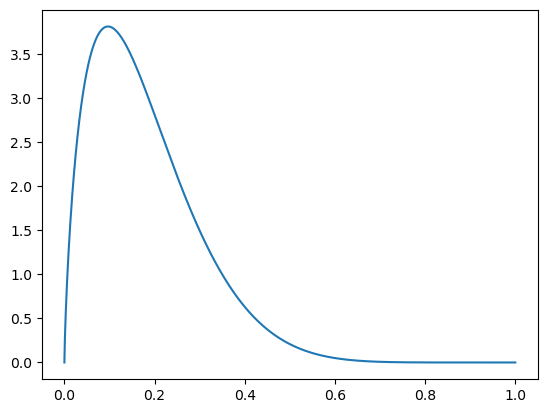

In [31]:
xl = np.linspace(0, 1, 1000)
plt.plot(xl, stats.beta.pdf(xl, 1.75, 8))

In [32]:
folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 987974)

In [33]:
clf = LGBMClassifier(objective = "binary", class_weight = 'balanced')

In [34]:
impute_grid_template = {
    "objective" : "poisson"
}

impute_grid= {}

keys = x.columns.values[x.isna().any()] 

for i in keys: 

    impute_grid[i] = impute_grid_template.copy()

    if "stds_" in i: 
        impute_grid[i]["objective"] = "binary"

In [35]:
impute_grid

{'n_sexual_partners': {'objective': 'poisson'},
 'first_sexual_intercourse': {'objective': 'poisson'},
 'n_pregnancies': {'objective': 'poisson'},
 'smokes_years': {'objective': 'poisson'},
 'smokes_packs_year': {'objective': 'poisson'},
 'hormonal_bc_years': {'objective': 'poisson'},
 'iud_years': {'objective': 'poisson'},
 'stds_condylomatosis': {'objective': 'binary'},
 'stds_vaginal_condylomatosis': {'objective': 'binary'},
 'stds_vulvo_perineal_condylomatosis': {'objective': 'binary'},
 'stds_syphilis': {'objective': 'binary'},
 'stds_pelvic_inflammatory_disease': {'objective': 'binary'},
 'stds_genital_herpes': {'objective': 'binary'},
 'stds_molluscum_contagiosum': {'objective': 'binary'},
 'stds_hiv': {'objective': 'binary'},
 'stds_hepatitis_b': {'objective': 'binary'},
 'stds_hpv': {'objective': 'binary'},
 'n_stds': {'objective': 'poisson'}}

In [36]:
mean_match = mean_match_default.copy()
mean_match.set_mean_match_candidates(5)

In [37]:
stds_indicator = ColumnTransformer(
    [("indicator", MissingIndicator(), ["stds_hpv"])],
    remainder='passthrough'
)

simple_union = FeatureUnion(
    transformer_list=[
         ('features', SimpleImputer(strategy='median')),
         ('indicator', stds_indicator)]
)

mice_union = FeatureUnion(
    transformer_list=[
         ('features', mice_imputer(mean_match_scheme = mean_match)),
         ('indicator', stds_indicator)]
)

std_cols = np.where(df.columns.str.startswith("stds"))[0]

pca_stds = ColumnTransformer(
    [("pca", PCA(n_components = 5),  std_cols)],
    remainder = "passthrough"
)


In [38]:
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=0)
pipe = Pipeline(
    memory = memory,
    steps = [
        ("imputer", simple_union),
        ("pca", pca_stds),
        ("classifier", clf)
    ]
)

In [39]:
grid = [
    {
    "imputer" : [simple_union],
    "imputer__features__strategy" : ["mean", "median"],
    "pca__pca__n_components" : stats.randint(1, 8),
    "classifier__n_estimators" : stats.nbinom(n = 2, p = .0075),
    "classifier__max_depth" : stats.randint(1, 10),
    "classifier__learning_rate" : stats.beta(1.5, 9),
    "classifier__min_child_samples" : stats.randint(3, 75),
    "classifier__cat_smooth" : stats.uniform(0, 25)
    },
    {"imputer" : [mice_union],
    "pca__pca__n_components" : stats.randint(1, 8),
    "classifier__n_estimators" : stats.nbinom(n = 2, p = .0075),
    "classifier__max_depth" : stats.randint(1, 10),
    "classifier__learning_rate" : stats.beta(1.5, 9),
    "classifier__min_child_samples" : stats.randint(3, 75),
    "classifier__cat_smooth" : stats.uniform(0, 25),
    "imputer__features__mice_iterations" : stats.randint(5, 20),
    "imputer__features__lgb_iterations" : stats.nbinom(n = 2, p = .0075),
    "imputer__features__lgb_learning_rate" : stats.beta(1.75, 8),
    "imputer__features__lgb_max_depth" : stats.randint(1, 10),
    "imputer__features__lgb_cat_smooth" : stats.uniform(0, 25),
    "imputer__features__lgb_feature_fraction_bynode" : stats.uniform(0, 1)
    }
]

In [40]:
from sklearn.metrics import fbeta_score, make_scorer
f3_scorer = make_scorer(fbeta_score, beta = 3)

gcv = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = grid, 
    scoring = f3_scorer,
    refit = True, 
    cv = folds,
    return_train_score = True,
    n_jobs = 19,
    n_iter = 10,
    random_state = 97417
)

gcv.fit(x_train, y_train.values.flatten())
rmtree(cachedir)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=987974),
                   estimator=Pipeline(steps=[('imputer',
                                              FeatureUnion(transformer_list=[('features',
                                                                              SimpleImputer(strategy='median')),
                                                                             ('indicator',
                                                                              ColumnTransformer(remainder='passthrough',
                                                                                                transformers=[('indicator',
                                                                                                               MissingIndicator(),
                                                                                                               ['stds_hpv'])]))])),
                                             ('pca',
                                              ColumnTransformer...
                                         'imputer__features__lgb_max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa760343910>,
                                         'imputer__features__mice_iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa7603414e0>,
                                         'pca__pca__n_components': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa7603400a0>}],
                   random_state=97417, return_train_score=True,
                   scoring=make_scorer(fbeta_score, beta=3))

In [41]:
gcv.best_estimator_

Pipeline(steps=[('imputer',
                 FeatureUnion(transformer_list=[('features',
                                                 mice_imputer(lgb_cat_smooth=14.449567505986986,
                                                              lgb_feature_fraction_bynode=0.8184728179680271,
                                                              lgb_iterations=169,
                                                              lgb_learning_rate=0.08545126867292037,
                                                              lgb_max_depth=7,
                                                              mean_match_scheme=<miceforest.MeanMatchScheme.MeanMatchScheme object at 0x7fa750b8fd60>,
                                                              mice_iterations=6)),
                                                ('indica...
                                                                                  MissingIndicator(),
                                                                                  ['stds_hpv'])]))])),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=6),
                                                  array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]))])),
                ('classifier',
                 LGBMClassifier(cat_smooth=10.847391965320988,
                                class_weight='balanced',
                                learning_rate=0.018644275692405437, max_depth=3,
                                min_child_samples=33, n_estimators=223,
                                objective='binary'))])

In [42]:
res[res.columns[res.columns.str.endswith("test_score")]].drop(["mean_test_score", "std_test_score", "rank_test_score"], axis = 1).mean(axis = 1).max()

NameError: name 'res' is not defined

In [ ]:
res = pd.DataFrame(gcv.cv_results_)
res[res.columns[res.columns.str.contains("param_|test_score", regex = True)]].sort_values("rank_test_score", ascending = True).head(15)

In [ ]:
stds = df[df.columns.values[df.columns.str.startswith("stds_")]].drop("stds_number", axis = 1).dropna()

In [ ]:
stds_str = stds.astype("string").replace(["0", "1"], ["no", "yes"])